## K-Means Clustering

**Overview**<br>
<a href="https://archive.ics.uci.edu/ml/datasets/online+retail">Online retail is a transnational data set</a> which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

The steps are broadly:
1. Read and understand the data
2. Clean the data
3. Prepare the data for modelling
4. Modelling
5. Final analysis and reco

# 1. Read and visualise the data

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [4]:
# read the dataset
retail_df = pd.read_csv("Online+Retail.csv", sep=",", encoding="ISO-8859-1", header=0)
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6.0,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [5]:
# basics of the df
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61879 entries, 0 to 61878
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   InvoiceNo    61879 non-null  object 
 1   StockCode    61879 non-null  object 
 2   Description  61716 non-null  object 
 3   Quantity     61878 non-null  float64
 4   InvoiceDate  61878 non-null  object 
 5   UnitPrice    61878 non-null  float64
 6   CustomerID   38377 non-null  float64
 7   Country      61878 non-null  object 
dtypes: float64(3), object(5)
memory usage: 3.8+ MB


# 2. Clean the data

In [6]:
# missing values
round(100*(retail_df.isnull().sum())/len(retail_df), 2)

InvoiceNo       0.00
StockCode       0.00
Description     0.26
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     37.98
Country         0.00
dtype: float64

In [7]:
# drop all rows having missing values
retail_df = retail_df.dropna()
retail_df.shape

(38377, 8)

In [8]:
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6.0,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [9]:
# new column: amount 
retail_df['amount'] = retail_df['Quantity']*retail_df['UnitPrice']
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,01-12-2010 08:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6.0,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,01-12-2010 08:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34


# 3. Prepare the data for modelling

- R (Recency): Number of days since last purchase
- F (Frequency): Number of tracsactions
- M (Monetary): Total amount of transactions (revenue contributed)

In [10]:
# monetary
grouped_df = retail_df.groupby('CustomerID')['amount'].sum()
grouped_df = grouped_df.reset_index()
grouped_df.head()

,CustomerID,amount
0,12346.0,0.00
1,12347.0,711.79
2,12348.0,892.80
3,12356.0,2271.62
4,12359.0,547.50


In [11]:
# frequency
frequency = retail_df.groupby('CustomerID')['InvoiceNo'].count()
frequency = frequency.reset_index()
frequency.columns = ['CustomerID', 'frequency']
frequency.head()

,CustomerID,frequency
0,12346.0,2
1,12347.0,31
2,12348.0,17
3,12356.0,36
4,12359.0,16


In [12]:
# merge the two dfs
grouped_df = pd.merge(grouped_df, frequency, on='CustomerID', how='inner')
grouped_df.head()

,CustomerID,amount,frequency
0,12346.0,0.00,2
1,12347.0,711.79,31
2,12348.0,892.80,17
3,12356.0,2271.62,36
4,12359.0,547.50,16


In [13]:
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,01-12-2010 08:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6.0,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,01-12-2010 08:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34


In [14]:
# recency
# convert to datetime
retail_df['InvoiceDate'] = pd.to_datetime(retail_df['InvoiceDate'], 
                                          format='%d-%m-%Y %H:%M')

In [15]:
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [16]:
# compute the max date
max_date = max(retail_df['InvoiceDate'])
max_date

Timestamp('2011-01-18 13:38:00')

In [17]:
# compute the diff
retail_df['diff'] = max_date - retail_df['InvoiceDate']
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount,diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,48 days 05:12:00
1,536365,71053,WHITE METAL LANTERN,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,48 days 05:12:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,48 days 05:12:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,48 days 05:12:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,48 days 05:12:00


In [18]:
# recency
last_purchase = retail_df.groupby('CustomerID')['diff'].min()
last_purchase = last_purchase.reset_index()
last_purchase.head()

,CustomerID,diff
0,12346.0,0 days 03:21:00
1,12347.0,41 days 22:41:00
2,12348.0,32 days 18:29:00
3,12356.0,0 days 03:48:00
4,12359.0,6 days 00:55:00


In [19]:
# merge
grouped_df = pd.merge(grouped_df, last_purchase, on='CustomerID', how='inner')
grouped_df.columns = ['CustomerID', 'amount', 'frequency', 'recency']
grouped_df.head()

,CustomerID,amount,frequency,recency
0,12346.0,0.00,2,0 days 03:21:00
1,12347.0,711.79,31,41 days 22:41:00
2,12348.0,892.80,17,32 days 18:29:00
3,12356.0,2271.62,36,0 days 03:48:00
4,12359.0,547.50,16,6 days 00:55:00


In [20]:
# number of days only
grouped_df['recency'] = grouped_df['recency'].dt.days
grouped_df.head()

,CustomerID,amount,frequency,recency
0,12346.0,0.00,2,0
1,12347.0,711.79,31,41
2,12348.0,892.80,17,32
3,12356.0,2271.62,36,0
4,12359.0,547.50,16,6


{'boxes': [<matplotlib.lines.Line2D at 0x7fa9c3a83c90>],
 'caps': [<matplotlib.lines.Line2D at 0x7fa9c3c12d50>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fa9c3a83210>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fa9c3c19850>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7fa9c3c122d0>,
  <matplotlib.lines.Line2D at 0x7fa9c3c12810>]}

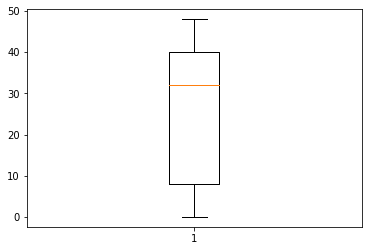

In [21]:
# 1. outlier treatment
plt.boxplot(grouped_df['recency'])

In [22]:
# two types of outliers:
# - statistical
# - domain specific

In [23]:
# removing (statistical) outliers
Q1 = grouped_df.amount.quantile(0.05)
Q3 = grouped_df.amount.quantile(0.95)
IQR = Q3 - Q1
grouped_df = grouped_df[(grouped_df.amount >= Q1 - 1.5*IQR) & (grouped_df.amount <= Q3 + 1.5*IQR)]

# outlier treatment for recency
Q1 = grouped_df.recency.quantile(0.05)
Q3 = grouped_df.recency.quantile(0.95)
IQR = Q3 - Q1
grouped_df = grouped_df[(grouped_df.recency >= Q1 - 1.5*IQR) & (grouped_df.recency <= Q3 + 1.5*IQR)]

# outlier treatment for frequency
Q1 = grouped_df.frequency.quantile(0.05)
Q3 = grouped_df.frequency.quantile(0.95)
IQR = Q3 - Q1
grouped_df = grouped_df[(grouped_df.frequency >= Q1 - 1.5*IQR) & (grouped_df.frequency <= Q3 + 1.5*IQR)]



In [24]:
# 2. rescaling
rfm_df = grouped_df[['amount', 'frequency', 'recency']]

# instantiate
scaler = StandardScaler()

# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(1149, 3)

In [25]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['amount', 'frequency', 'recency']
rfm_df_scaled.head()

,amount,frequency,recency
0,-0.821546,-0.898718,-1.605070
1,0.325820,0.057357,0.958091
2,0.617598,-0.404196,0.395446
3,2.840179,0.222198,-1.605070
4,0.060993,-0.437164,-1.229974


# 4. Modelling

In [26]:
# k-means with some arbitrary k
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=4)

In [27]:
kmeans.labels_

array([3, 0, 0, ..., 3, 0, 3], dtype=int32)

In [28]:
# help(KMeans)

## Finding the Optimal Number of Clusters

### SSD

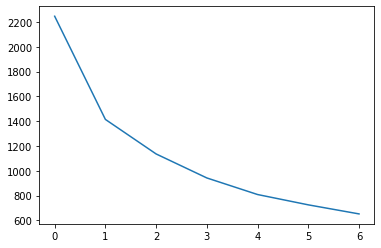

In [29]:
# elbow-curve/SSD
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
# ssd
plt.plot(ssd)

### Silhouette Analysis

$$\text{silhouette score}=\frac{p-q}{max(p,q)}$$

$p$ is the mean distance to the points in the nearest cluster that the data point is not a part of

$q$ is the mean intra-cluster distance to all the points in its own cluster.

* The value of the silhouette score range lies between -1 to 1. 

* A score closer to 1 indicates that the data point is very similar to other data points in the cluster, 

* A score closer to -1 indicates that the data point is not similar to the data points in its cluster.

In [30]:
# silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))
    
    

For n_clusters=2, the silhouette score is 0.42394730660328905
For n_clusters=3, the silhouette score is 0.47667748580187275
For n_clusters=4, the silhouette score is 0.48217160266444437
For n_clusters=5, the silhouette score is 0.44769022041498346
For n_clusters=6, the silhouette score is 0.43216102716943783
For n_clusters=7, the silhouette score is 0.4089736399508808
For n_clusters=8, the silhouette score is 0.4293098734053277


In [31]:
# final model with k=3
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=3)

In [32]:
kmeans.labels_

array([2, 1, 1, ..., 2, 1, 2], dtype=int32)

In [33]:
# assign the label
grouped_df['cluster_id'] = kmeans.labels_
grouped_df.head()

,CustomerID,amount,frequency,recency,cluster_id
0,12346.0,0.00,2,0,2
1,12347.0,711.79,31,41,1
2,12348.0,892.80,17,32,1
3,12356.0,2271.62,36,0,0
4,12359.0,547.50,16,6,2


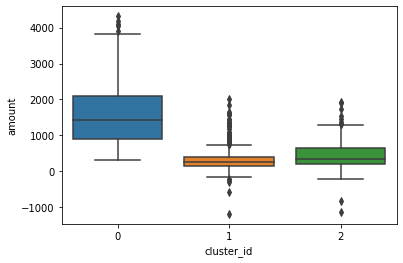

In [34]:
# plot
sns.boxplot(x='cluster_id', y='amount', data=grouped_df)

## Hierarchical Clustering

In [35]:
rfm_df_scaled.head()

,amount,frequency,recency
0,-0.821546,-0.898718,-1.605070
1,0.325820,0.057357,0.958091
2,0.617598,-0.404196,0.395446
3,2.840179,0.222198,-1.605070
4,0.060993,-0.437164,-1.229974


In [36]:
grouped_df.head()

,CustomerID,amount,frequency,recency,cluster_id
0,12346.0,0.00,2,0,2
1,12347.0,711.79,31,41,1
2,12348.0,892.80,17,32,1
3,12356.0,2271.62,36,0,0
4,12359.0,547.50,16,6,2


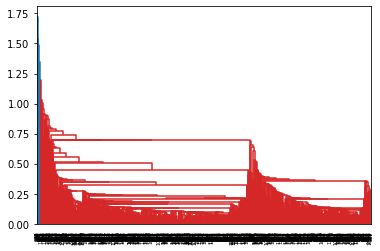

In [37]:
# single linkage
mergings = linkage(rfm_df_scaled, method="single", metric='euclidean')
dendrogram(mergings)
plt.show()

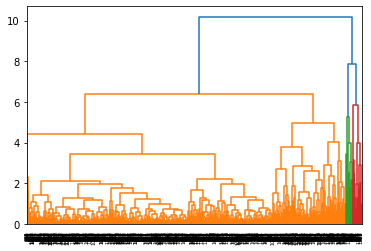

In [38]:
# complete linkage
mergings = linkage(rfm_df_scaled, method="complete", metric='euclidean')
dendrogram(mergings)
plt.show()

In [39]:
# 3 clusters
cluster_labels = cut_tree(mergings, n_clusters=3).reshape(-1, )
cluster_labels

array([0, 0, 0, ..., 0, 0, 0])

In [40]:
# assign cluster labels
grouped_df['cluster_labels'] = cluster_labels
grouped_df.head()

,CustomerID,amount,frequency,recency,cluster_id,cluster_labels
0,12346.0,0.00,2,0,2,0
1,12347.0,711.79,31,41,1,0
2,12348.0,892.80,17,32,1,0
3,12356.0,2271.62,36,0,0,0
4,12359.0,547.50,16,6,2,0


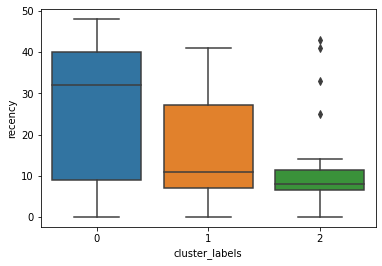

In [41]:
# plots
sns.boxplot(x='cluster_labels', y='recency', data=grouped_df)

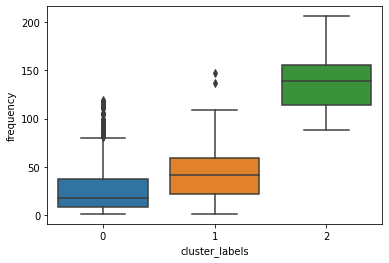

In [42]:
# plots
sns.boxplot(x='cluster_labels', y='frequency', data=grouped_df)

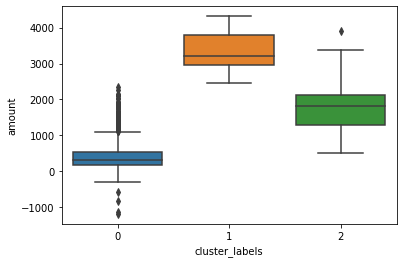

In [43]:
# plots
sns.boxplot(x='cluster_labels', y='amount', data=grouped_df)